# Projet - ITK/VTK - Etude longitudinale de l’évolution d’une tumeur

In [15]:
import numpy as np
import itk
import matplotlib.pyplot as plt
print(itk.Version.GetITKVersion())

5.3.0


In [55]:
# get the output image
PixelType = itk.F

images_1 = itk.imread("./Data/case6_gre1.nrrd", PixelType)
images_2 = itk.imread("./Data/case6_gre2.nrrd", PixelType)

images_1.shape, images_2.shape

((176, 256, 256), (176, 256, 256))

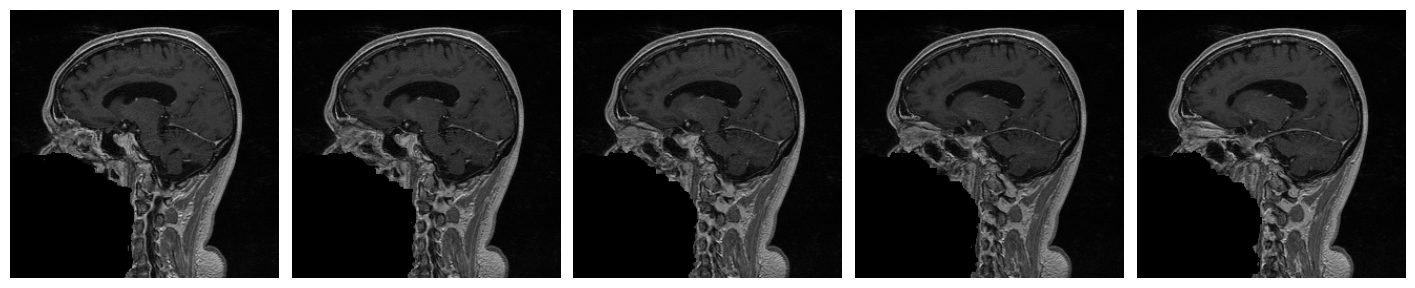

In [17]:
def print_5_slices(images, index_slice, dimension) :
    fig, axs = plt.subplots(1, 5, figsize=(18, 8))
    
    if dimension == 1 :
        if index_slice > images.shape[0] :
            raise ValueError("index_slice is higher than the number of slices")
        
        limit = index_slice
        i = 0
        while limit < images.shape[0] and i < 5 :
            limit += 1
            i += 1
        
        j = 0
        for i in range(index_slice, limit) :
            axs[j].imshow(images[i, :, :], cmap='gray')
            axs[j].axis('off')
            j += 1
    
    elif dimension >= 2 :
        if index_slice > images.shape[1] :
            raise ValueError("index_slice is higher than the number of slices")
        
        limit = index_slice
        i = 0
        while limit < images.shape[0] and i < 5 :
            limit += 1
            i += 1

        j = 0
        if dimension == 2 :
            for i in range(index_slice, limit) :
                axs[j].imshow(images[:, i, :], cmap='gray')
                axs[j].axis('off')
                j += 1
        else :
            for i in range(index_slice, limit) :
                axs[j].imshow(images[:, :, i], cmap='gray')
                axs[j].axis('off')
                j += 1
                
    plt.subplots_adjust(wspace=0.05)

print_5_slices(images_1, 100, 1)

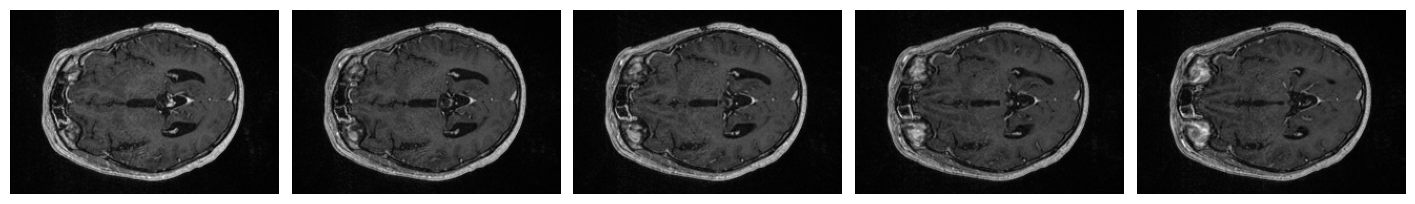

In [18]:
print_5_slices(images_1, 100, 2)

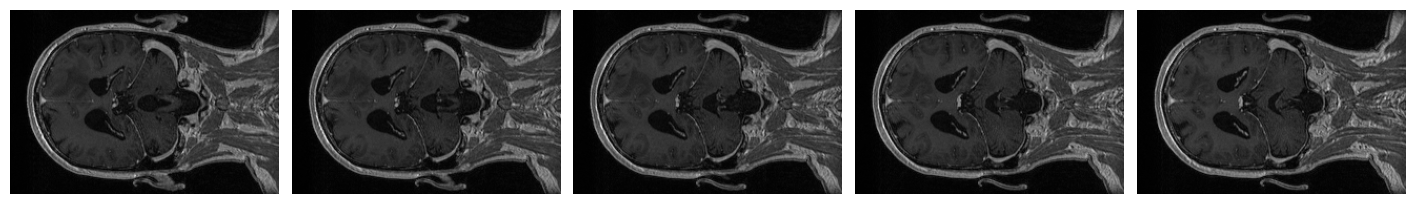

In [19]:
print_5_slices(images_1, 150, 3)

## Etape 1 - Recalage

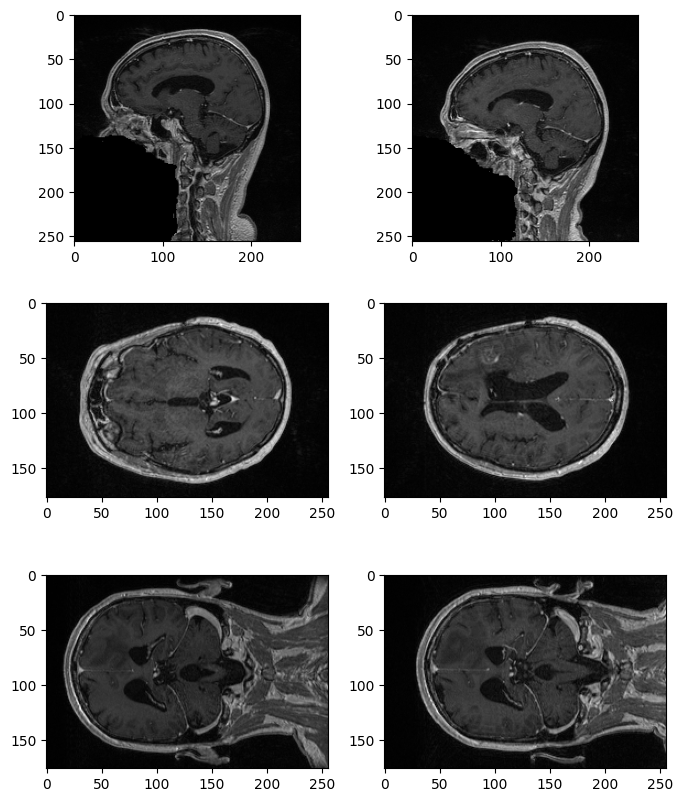

In [20]:
fig, axes = plt.subplots(3, 2, figsize=(8, 10))
axes[0, 0].imshow(images_1[100, :, :], cmap='gray')
axes[0, 1].imshow(images_2[100, :, :], cmap='gray')
axes[1, 0].imshow(images_1[:, 100, :], cmap='gray')
axes[1, 1].imshow(images_2[:, 100, :], cmap='gray')
axes[2, 0].imshow(images_1[:, :, 150], cmap='gray')
axes[2, 1].imshow(images_2[:, :, 150], cmap='gray')

On peut remarquer qu'il y a une différence marquée d'aligement latéral entre les deux images. Nous effectuerons donc un recalage par translation pour aligner nos images.

In [21]:
dimension = 3
FixedImageType = type(images_1)
MovingImageType = type(images_2)

TransformType = itk.TranslationTransform[itk.D, dimension]
initialTransform = TransformType.New()

optimizer = itk.RegularStepGradientDescentOptimizerv4.New()

optimizer.SetLearningRate(1)
optimizer.SetMinimumStepLength(1e-6)
optimizer.SetNumberOfIterations(100)

metric = itk.MeanSquaresImageToImageMetricv4[FixedImageType, MovingImageType].New()
fixed_interpolation = itk.LinearInterpolateImageFunction[FixedImageType, itk.D].New()
metric.SetFixedInterpolator(fixed_interpolation)

registration = itk.ImageRegistrationMethodv4[FixedImageType, MovingImageType].New(FixedImage=images_1, MovingImage=images_2, Metric=metric,
                                                                                    Optimizer=optimizer, InitialTransform=initialTransform)

moving_initial_transform = TransformType.New()
initial_parameters = moving_initial_transform.GetParameters()
initial_parameters[0] = 0
initial_parameters[1] = 0
moving_initial_transform.SetParameters(initial_parameters)
registration.SetMovingInitialTransform(moving_initial_transform)

identity_transform = TransformType.New()
identity_transform.SetIdentity()
registration.SetFixedInitialTransform(identity_transform)

registration.SetNumberOfLevels(1)

registration.Update()

transform = registration.GetTransform()
final_parameters = transform.GetParameters()
translation_along_x = final_parameters.GetElement(0)
translation_along_y = final_parameters.GetElement(1)
translation_along_z = final_parameters.GetElement(2)

number_of_iterations = optimizer.GetCurrentIteration()

best_value = optimizer.GetValue()

print("Result = ")
print(" Translation X = " + str(translation_along_x))
print(" Translation Y = " + str(translation_along_y))
print(" Translation Z = " + str(translation_along_z))
print(" Iterations    = " + str(number_of_iterations))
print(" Metric value  = " + str(best_value))

Result = 
 Translation X = -0.7927484241835651
 Translation Y = -3.5743807654084585
 Translation Z = -59.61025848317227
 Iterations    = 89
 Metric value  = 5614.108711314411


In [22]:
resampler = itk.ResampleImageFilter.New(Input=images_2, Transform=transform, UseReferenceImage=True,
                                        ReferenceImage=images_1)
resampler.SetDefaultPixelValue(0)

OutputImageType = itk.Image[PixelType, dimension]
images_2_resampled_casted = itk.CastImageFilter[FixedImageType, OutputImageType].New(resampler)

images_2_resampled = itk.array_from_image(images_2_resampled_casted)

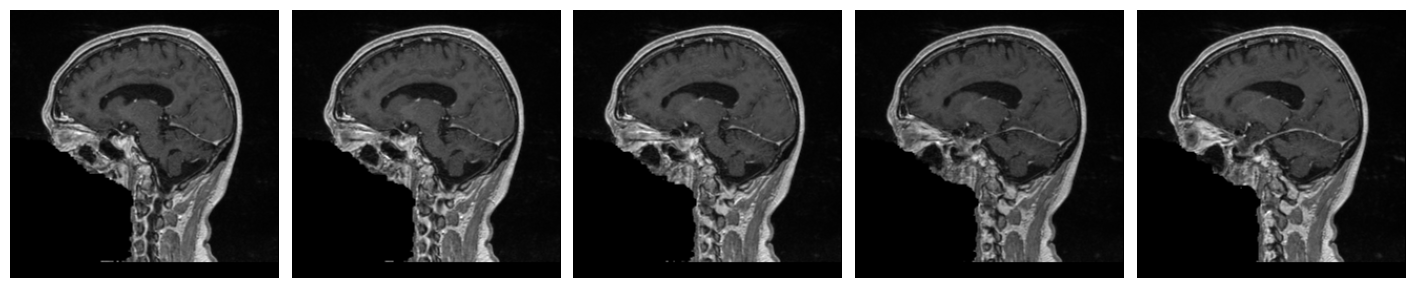

In [23]:
print_5_slices(images_2_resampled, 100, 1)

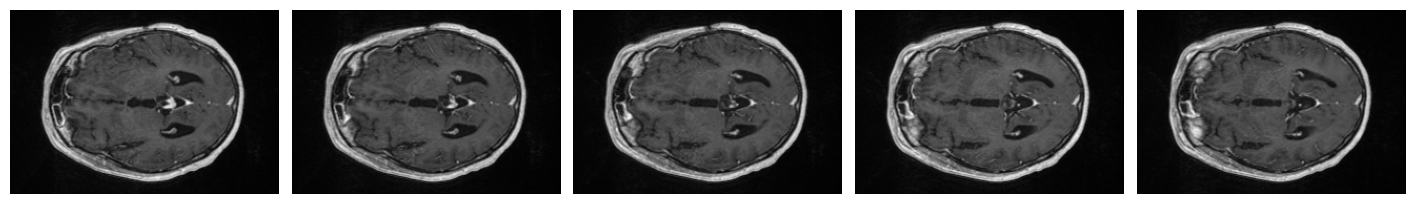

In [24]:
print_5_slices(images_2_resampled, 100, 2)

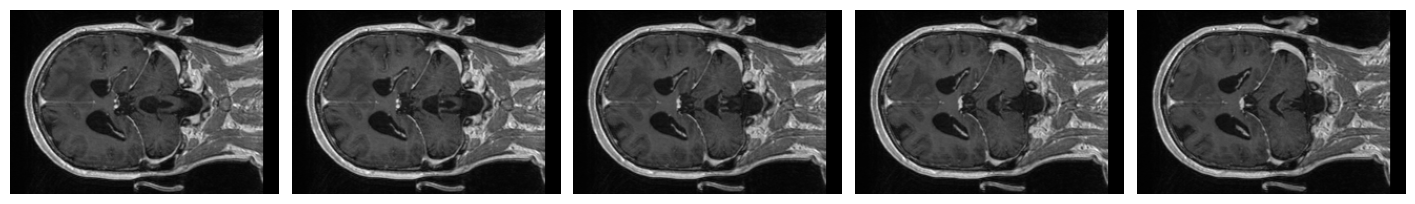

In [25]:
print_5_slices(images_2_resampled, 150, 3)

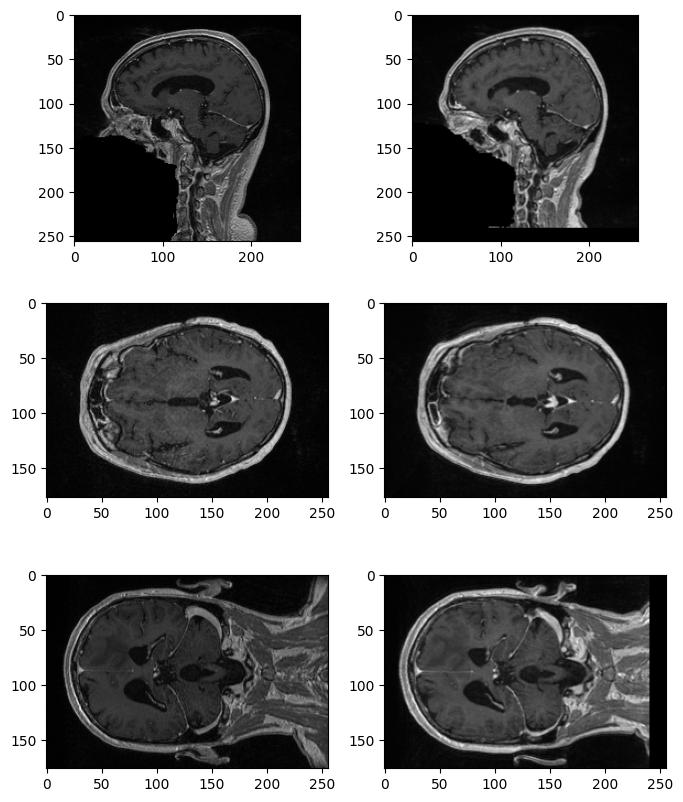

In [26]:
fig, axes = plt.subplots(3, 2, figsize=(8, 10))
axes[0, 0].imshow(images_1[100, :, :], cmap='gray')
axes[0, 1].imshow(images_2_resampled[100, :, :], cmap='gray')
axes[1, 0].imshow(images_1[:, 100, :], cmap='gray')
axes[1, 1].imshow(images_2_resampled[:, 100, :], cmap='gray')
axes[2, 0].imshow(images_1[:, :, 150], cmap='gray')
axes[2, 1].imshow(images_2_resampled[:, :, 150], cmap='gray')

## Etape 2 - Ségmentation

Après analyse visuelle, nous avons remarqué que l'intensité des valeurs de la tumeur variait de 50 à 106 pour l'image 1 et de 50 à 100 pour l'image 2.

Nous avons ainsi selectionné deux points appartenant à la tumeur pour l'image 1 et pour l'image 2, et avons effectué notre segmentation de tumeur sur chacune des images 3D.

In [ ]:
images_2_resampled = images_2_resampled.astype(float)
images_2_resampled = itk.image_from_array(images_2_resampled)

In [79]:
# Create the CastImageFilter and set the input and output pixel types
cast_filter = itk.CastImageFilter[images_2_resampled, itk.Image[itk.F, 3]].New()
cast_filter.SetInput(images_2_resampled)
cast_filter.Update()

# Get the casted image
images_2_resampled = cast_filter.GetOutput()

In [80]:
smoothing = itk.CurvatureFlowImageFilter.New(Input=images_1)
smoothing.SetNumberOfIterations(5)
smoothing.SetTimeStep(0.125)
smoothing.Update()

images_1_smoothed = smoothing.GetOutput()

smoothing = itk.CurvatureFlowImageFilter.New(Input=images_2_resampled)
smoothing.SetNumberOfIterations(5)
smoothing.SetTimeStep(0.125)
smoothing.Update()

images_2_smoothed = smoothing.GetOutput()

images_1_smoothed.shape, images_2_smoothed.shape

((176, 256, 256), (176, 256, 256))

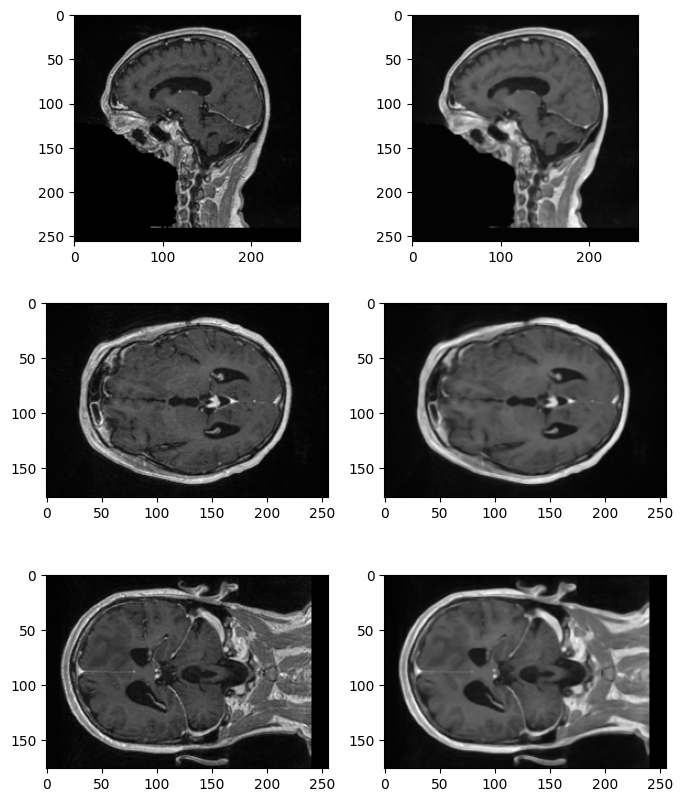

In [92]:
fig, axes = plt.subplots(3, 2, figsize=(8, 10))
axes[0, 0].imshow(images_2_resampled[100, :, :], cmap='gray')
axes[0, 1].imshow(images_2_smoothed[100, :, :], cmap='gray')
axes[1, 0].imshow(images_2_resampled[:, 100, :], cmap='gray')
axes[1, 1].imshow(images_2_smoothed[:, 100, :], cmap='gray')
axes[2, 0].imshow(images_2_resampled[:, :, 150], cmap='gray')
axes[2, 1].imshow(images_2_smoothed[:, :, 150], cmap='gray')

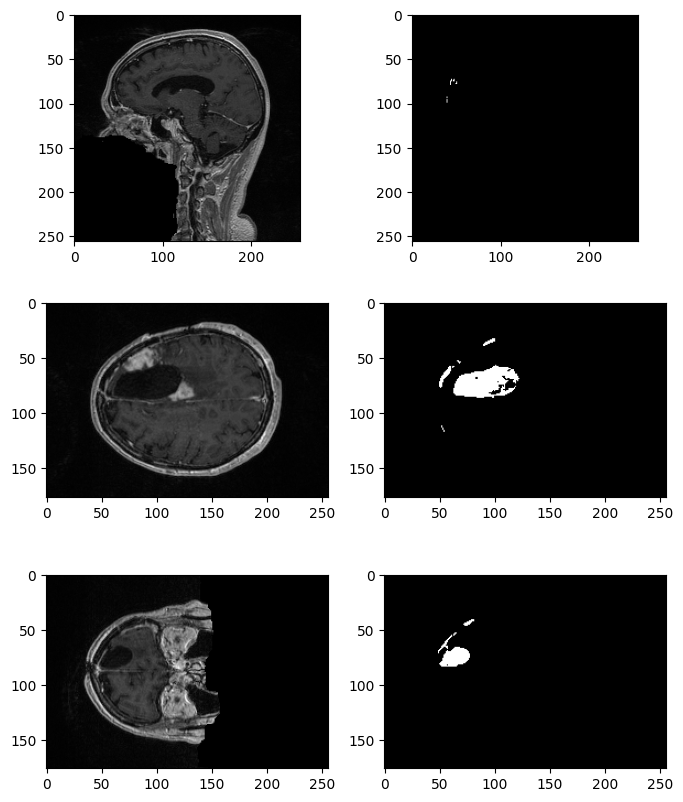

In [104]:
# Perform segmentation on images_1_smoothed
ConnectedFilterType = itk.ConnectedThresholdImageFilter[itk.Image[itk.F,3], itk.Image[itk.F,3]]
connectedThreshold = ConnectedFilterType.New()

lower_threshold = 50.
upper_threshold = 106.

connectedThreshold.SetInput(images_1_smoothed)
connectedThreshold.SetLower(lower_threshold)
connectedThreshold.SetUpper(upper_threshold)
connectedThreshold.SetReplaceValue(255)

index = (100,64,68)
connectedThreshold.SetSeed(index)
seed_value = images_1_smoothed.GetPixel(index)

connectedThreshold.Update()

images_1_segmented = connectedThreshold.GetOutput()

#for i in range(images_1_segmented.shape[0]):
#    plt.imshow(images_1_segmented[i, :, :], cmap='gray')
#    plt.axis('off')    
#    plt.show()

fig, axes = plt.subplots(3, 2, figsize=(8, 10))
axes[0, 0].imshow(images_1[100, :, :], cmap='gray')
axes[0, 1].imshow(images_1_segmented[100, :, :], cmap='gray')
axes[1, 0].imshow(images_1[:, 64, :], cmap='gray')
axes[1, 1].imshow(images_1_segmented[:, 64, :], cmap='gray')
axes[2, 0].imshow(images_1[:, :, 68], cmap='gray')
axes[2, 1].imshow(images_1_segmented[:, :, 68], cmap='gray')

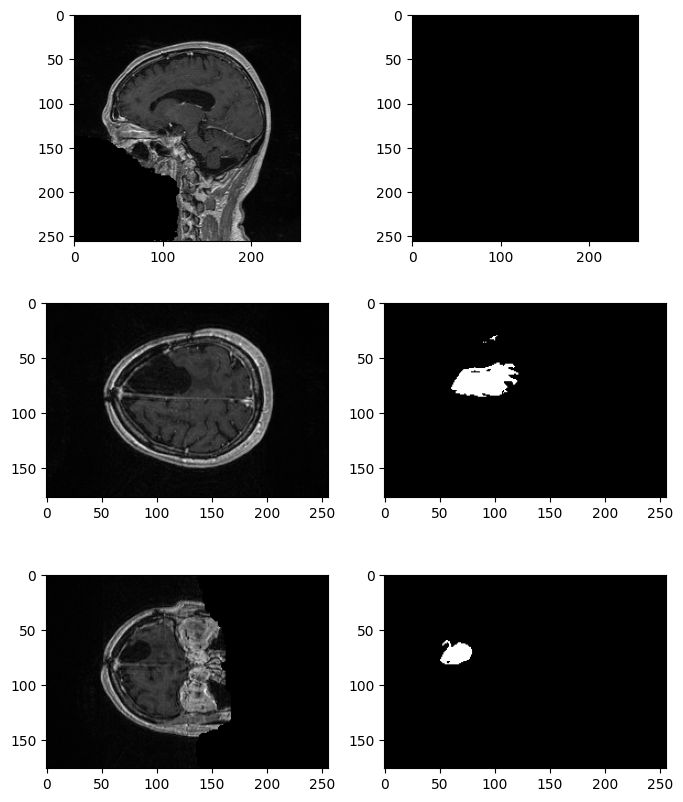

In [101]:
# Perform segmentation on images_2_smoothed
ConnectedFilterType = itk.ConnectedThresholdImageFilter[itk.Image[itk.F,3], itk.Image[itk.F,3]]
connectedThreshold = ConnectedFilterType.New()

lower_threshold = 50.
upper_threshold = 100.

connectedThreshold.SetInput(images_2_smoothed)
connectedThreshold.SetLower(lower_threshold)
connectedThreshold.SetUpper(upper_threshold)
connectedThreshold.SetReplaceValue(255)

index = (100,64,68)
connectedThreshold.SetSeed(index)
seed_value = images_2_smoothed.GetPixel((100,64,68))

connectedThreshold.Update()

images_2_segmented = connectedThreshold.GetOutput()

#for i in range(images_2_segmented.shape[0]):
#    plt.imshow(images_2_segmented[i, :, :], cmap='gray')
#    plt.axis('off')    
#    plt.show()

fig, axes = plt.subplots(3, 2, figsize=(8, 10))
axes[0, 0].imshow(images_2[100, :, :], cmap='gray')
axes[0, 1].imshow(images_2_segmented[100, :, :], cmap='gray')
axes[1, 0].imshow(images_2[:, 64, :], cmap='gray')
axes[1, 1].imshow(images_2_segmented[:, 64, :], cmap='gray')
axes[2, 0].imshow(images_2[:, :, 68], cmap='gray')
axes[2, 1].imshow(images_2_segmented[:, :, 68], cmap='gray')